In [2]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
uploaded = files.upload()

Saving monthly-electricity-production-2.csv to monthly-electricity-production-2.csv


In [4]:
data = pd.read_csv('monthly-electricity-production-2.csv')
data.head()

,electricity
1956-01,1254
1956-02,1290
1956-03,1379
1956-04,1346
1956-05,1535


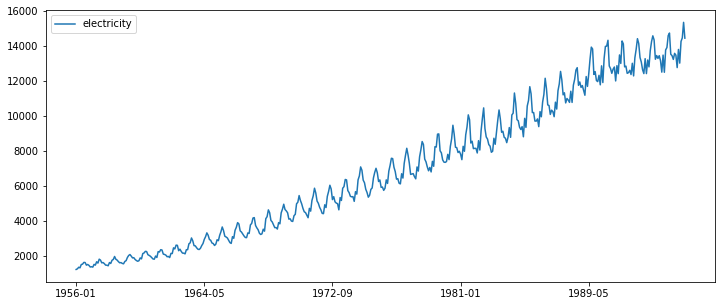

In [5]:
data.plot(figsize=(12,5))
plt.show()

## 1. Стабилизация дисперсии, дифференцирование ряда

In [6]:
data['electricity'] = data['electricity'] * 1000
data['electricity_box'], lmbda = boxcox(data['electricity'])
data['electricity_box_sdiff'] = data['electricity_box'].diff(12)
data['electricity_box_diff'] =  data['electricity_box_sdiff'].diff(1)

In [7]:
print("Критерий Дики-Фуллера для исходного ряда: p=%f" % adfuller(data['electricity'])[1])
print("После преобразования Бокса-Кокса: p=%f" % adfuller(data['electricity_box'])[1])
print("После сезонного дифференцирования: p=%f" % adfuller(data['electricity_box_sdiff'].dropna())[1])
print("После дополнительного дифференцирования: p=%f" % adfuller(data['electricity_box_diff'].dropna())[1])

Критерий Дики-Фуллера для исходного ряда: p=0.994098
После преобразования Бокса-Кокса: p=0.488288
После сезонного дифференцирования: p=0.011233
После дополнительного дифференцирования: p=0.000000


#2. Выбор гиперпараметров модели

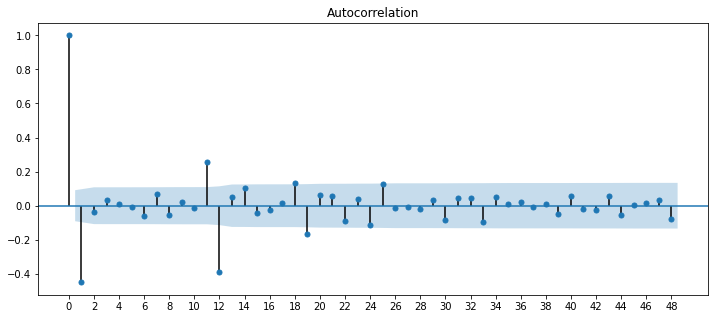

In [8]:
plt.rcParams['figure.figsize'] = (12,5)
plot_acf(data['electricity_box_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

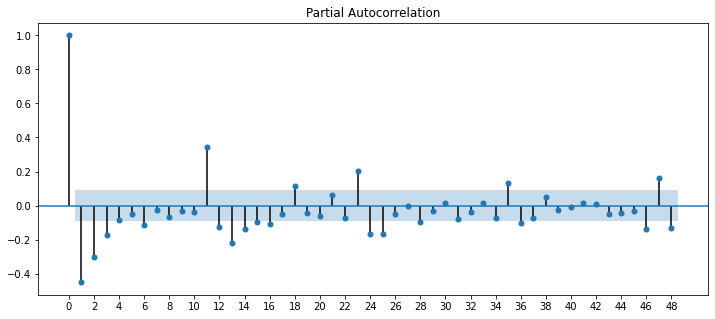

In [9]:
plt.rcParams['figure.figsize'] = (12,5)
plot_pacf(data['electricity_box_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Таким образом, будем рассматривать следующие наборы гиперпараметров модели SARIMA:

In [10]:
d=1
D=1
p = [0, 1, 2]
q = [0, 1, 2]
P = [0, 1, 2]
Q = [0, 1, 2]

In [11]:
parameters = product(p, q, P, Q)
parameters_list = list(parameters)

#3. Выбор оптимальной модели

In [12]:
results = []
best_aic = float('inf')

for params in parameters_list:
    try:
        model = SARIMAX(data['electricity_box'],
                        order=(params[0], d, params[1]), 
                        seasonal_order=(params[2], D, params[3], 12)).fit()
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = params
    results.append([params, model.aic])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so infer

In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())

      parameters          aic
16  (0, 1, 2, 1)  3405.044638
52  (1, 2, 2, 1)  3405.681339
46  (1, 2, 0, 1)  3406.337686
10  (0, 1, 0, 1)  3406.528424
43  (1, 1, 2, 1)  3406.719229


#4. Визуальзация результата

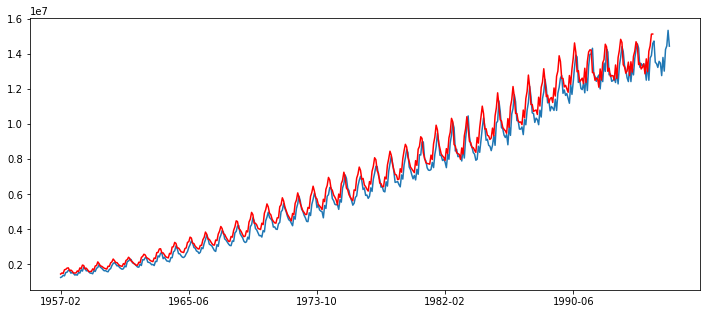

In [15]:
data['model'] = inv_boxcox(best_model.fittedvalues, lmbda)
data['electricity'].plot(figsize=(12,5))
data.model[13:].plot(color='r')
plt.show()

#5. Получение прогноза

In [16]:
df = pd.DataFrame({"a": ["20110003"]})
df["b"] = pd.to_datetime(df["a"], format='%Y00%m').apply(lambda x: x.strftime('%Y-%m'))
print(df["b"])

0    2011-03
Name: b, dtype: object


In [21]:
pd.to_datetime(prognosis.index, format='%Y-%m')

DatetimeIndex(['1995-01-01', '1995-02-01', '1995-03-01', '1995-04-01',
               '1995-05-01', '1995-06-01', '1995-07-01', '1995-08-01',
               '1995-09-01', '1995-10-01', '1995-11-01', '1995-12-01',
               '1996-01-01', '1996-02-01', '1996-03-01', '1996-04-01',
               '1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01', '1996-11-01', '1996-12-01',
               '1997-01-01', '1997-02-01', '1997-03-01', '1997-04-01',
               '1997-05-01', '1997-06-01', '1997-07-01', '1997-08-01',
               '1997-09-01', '1997-10-01', '1997-11-01', '1997-12-01',
               '1998-01-01', '1998-02-01', '1998-03-01', '1998-04-01',
               '1998-05-01', '1998-06-01', '1998-07-01', '1998-08-01',
               '1998-09-01'],
              dtype='datetime64[ns]', freq='MS')

In [18]:
prognosis = inv_boxcox(best_model.predict(start='1995-01', end='1998-09'), lmbda)

In [23]:
dates = []
for i in range(len(data['electricity'])):
  dates.append(data.index[i] + '-01')

In [25]:
data['dates'] = dates
data.head()

,electricity,electricity_box,electricity_box_sdiff,electricity_box_diff,model,dates
1956-01,1254000,607.536907,NaN,NaN,1.000000e+00,1956-01-01
1956-02,1290000,614.302281,NaN,NaN,1.253862e+06,1956-02-01
1956-03,1379000,630.547637,NaN,NaN,1.289997e+06,1956-03-01
1956-04,1346000,624.600881,NaN,NaN,1.378992e+06,1956-04-01
1956-05,1535000,657.544202,NaN,NaN,1.346003e+06,1956-05-01


In [26]:
data.set_index('dates',inplace=True)
data.head()

,electricity,electricity_box,electricity_box_sdiff,electricity_box_diff,model
dates,,,,,
1956-01-01,1254000,607.536907,NaN,NaN,1.000000e+00
1956-02-01,1290000,614.302281,NaN,NaN,1.253862e+06
1956-03-01,1379000,630.547637,NaN,NaN,1.289997e+06
1956-04-01,1346000,624.600881,NaN,NaN,1.378992e+06
1956-05-01,1535000,657.544202,NaN,NaN,1.346003e+06


In [36]:
presict_data = data['electricity']
presict_data

dates
1956-01-01     1254000
1956-02-01     1290000
1956-03-01     1379000
1956-04-01     1346000
1956-05-01     1535000
                ...   
1995-04-01    13032000
1995-05-01    14268000
1995-06-01    14473000
1995-07-01    15359000
1995-08-01    14457000
Name: electricity, Length: 476, dtype: int64

In [63]:
data.index
#inv_boxcox(best_model.predict(start='1995-09-01', end='1998-09-01'), lmbda).index

DatetimeIndex(['1956-01-01', '1956-02-01', '1956-03-01', '1956-04-01',
               '1956-05-01', '1956-06-01', '1956-07-01', '1956-08-01',
               '1956-09-01', '1956-10-01',
               ...
               '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01',
               '1995-03-01', '1995-04-01', '1995-05-01', '1995-06-01',
               '1995-07-01', '1995-08-01'],
              dtype='datetime64[ns]', name='dates', length=476, freq=None)

In [62]:
data.index = data.index.astype('datetime64[ns]')

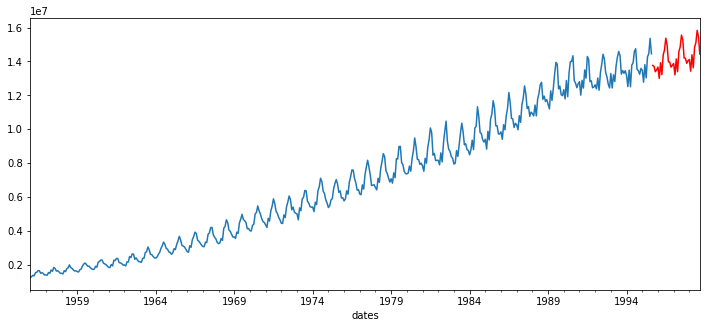

In [64]:
data['electricity'].plot(figsize=(12,5))
inv_boxcox(best_model.predict(start='1995-09-01', end='1998-09-01'), lmbda).plot(color='r')
plt.show()

#6. Prophet

In [66]:
data_prophet = data[['electricity']]
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y']
data_prophet.head()

,ds,y
0,1956-01-01,1254000
1,1956-02-01,1290000
2,1956-03-01,1379000
3,1956-04-01,1346000
4,1956-05-01,1535000


In [67]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.fit(data_prophet)

In [68]:
future = model.make_future_dataframe(periods=36, freq='MS')

In [69]:
forecast = model.predict(future)

In [70]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12)

,ds,yhat,yhat_lower,yhat_upper
500,1997-09-01,1.499991e+07,1.463224e+07,1.535765e+07
501,1997-10-01,1.495016e+07,1.457821e+07,1.531268e+07
502,1997-11-01,1.470245e+07,1.433322e+07,1.505503e+07
503,1997-12-01,1.467485e+07,1.427961e+07,1.502905e+07
504,1998-01-01,1.466012e+07,1.431137e+07,1.503674e+07
505,1998-02-01,1.445492e+07,1.407435e+07,1.482119e+07
506,1998-03-01,1.500787e+07,1.463336e+07,1.538304e+07
507,1998-04-01,1.474176e+07,1.438164e+07,1.513474e+07
508,1998-05-01,1.547641e+07,1.510101e+07,1.583880e+07
509,1998-06-01,1.571051e+07,1.530280e+07,1.608443e+07


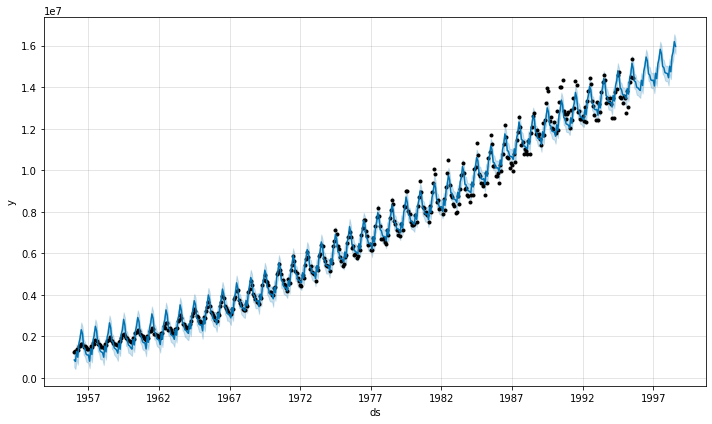

In [71]:
model.plot(forecast)
plt.show()

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.special import inv_boxcox

In [74]:
mean_squared_error(data['electricity'].values, forecast['yhat'][:-36].values)

78504163586.53235

In [75]:
mean_absolute_error(data['electricity'].values, forecast['yhat'][:-36].values)

208123.2940044811

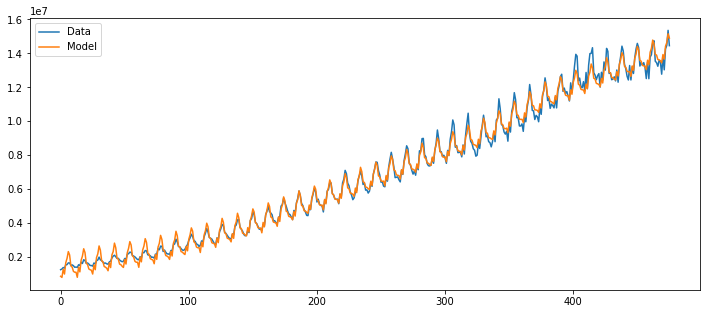

In [76]:
plt.plot(data['electricity'].values, label='Data')
plt.plot(forecast['yhat'][:-36].values, label='Model')
plt.legend()
plt.show()

#7. Сравним мадели SARIMAX vs Prophet

In [80]:
MSE_prophet = mean_squared_error(data['electricity'].values, forecast['yhat'][:-36].values)
MSE_SARIMAX = mean_squared_error(data['electricity'].values, data['model'].values)

In [82]:
print('MSE_prophet: {} \nMSE_SARIMAX: {}'.format(MSE_prophet, MSE_SARIMAX))

MSE_prophet: 78504163586.53235 
MSE_SARIMAX: 41134174681.74747


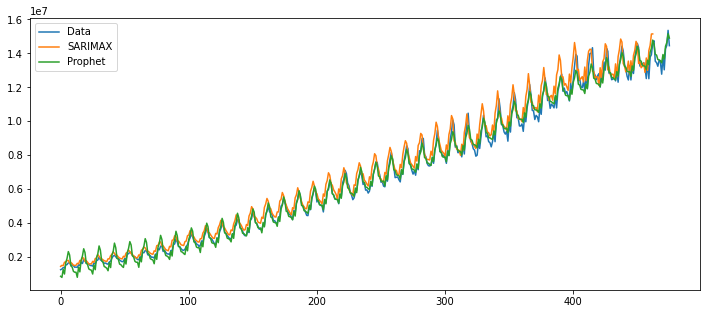

In [93]:
plt.plot(data['electricity'].values, label='Data')
plt.plot(data['model'][13:].values, label='SARIMAX')
plt.plot(forecast['yhat'][:-36].values, label='Prophet')
plt.legend()
plt.show()